# Link Prediction in the Dataset Of 1st Approach

Welcome to this Jupyter Notebook as we continue our journey into link prediction. In our earlier notebook, we established the foundation for predicting links using the **1st Approach**. This method **`connects less popular nodes to neighbors of more popular nodes to create a well-balanced dataset`**.

Now, we're using this Dataset to exploring link prediction using two different methods: Artificial Neural Networks (ANN) and Linear Regression. Our goal is to predict connections within our network and evaluate the performance of these approaches in identifying potential edges.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
df_train = pd.read_csv('monthly2_train.csv')
df_test = pd.read_csv('monthly2_test.csv')

### Exploring Feature Influence on Link Prediction Labels

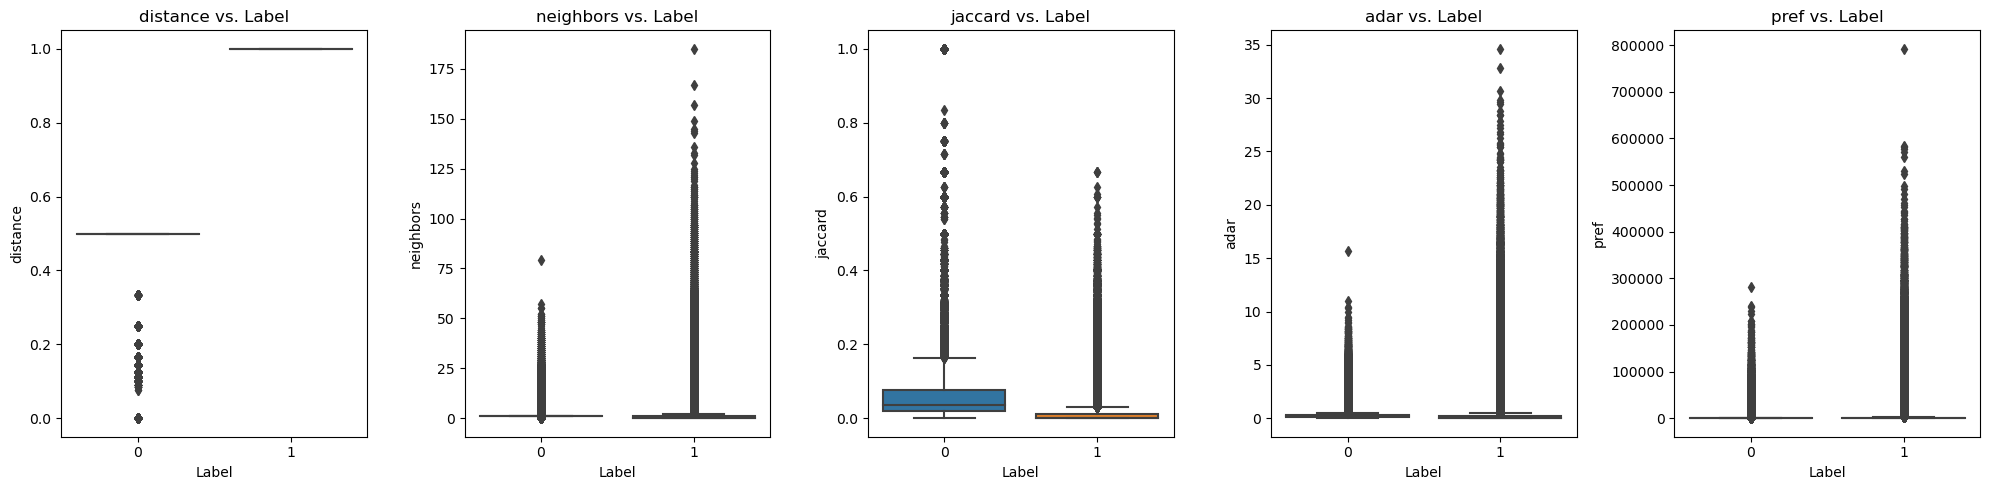

In [4]:
import seaborn as sns
feature_names = ['distance', 'neighbors', 'jaccard', 'adar', 'pref']
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, feature in enumerate(feature_names):
    sns.boxplot(x='label', y=feature, data=df_train, ax=axs[i])
    axs[i].set_title(f"{feature} vs. Label")
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

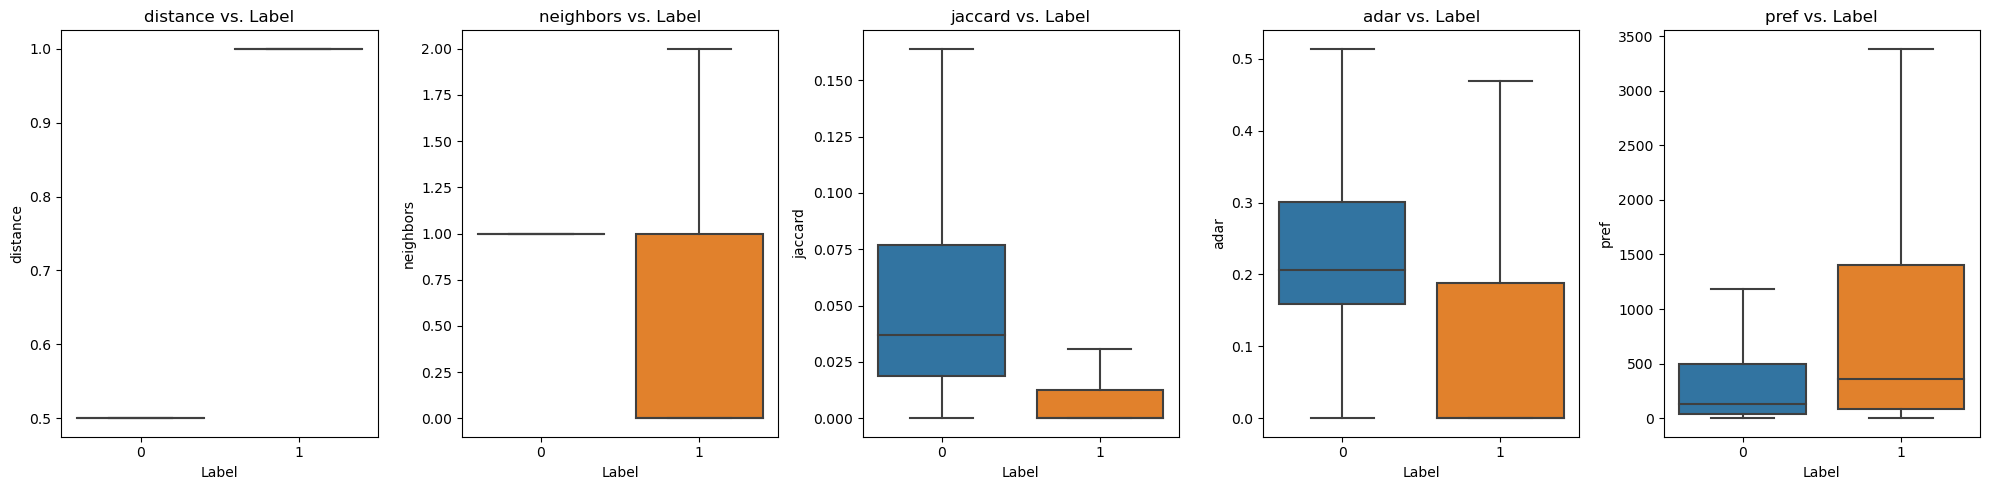

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, feature in enumerate(feature_names):
    sns.boxplot(x='label', y=feature, data=df_train, ax=axs[i], showfliers=False)
    axs[i].set_title(f"{feature} vs. Label")
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

We can observe some interesting patterns in these boxplots. For existing edges (label 1), the preferential attachment tends to have higher values compared to non-existing edges (label 0). On the other hand, in the remaining metrics like common neighbors, Jaccard coefficient, and Adamic-Adar, non-existing edges show slightly higher values.

    Distance Metric - A Special Case

However, there's a distinct case with the 'distance' metric. The 'distance' metric signifies the graph distance between nodes, and a distance of 1 directly indicates the presence of an existing edge (label 1). As a result, the 'distance' metric typically holds lower values for non-existing edges.

Due to this unique characteristic and the potential for the 'distance' metric to create trivial predictions (given that all existing edges have a distance of 1), we made the informed decision to exclude it from our prediction process.

This choice allows us to focus on the remaining informative features for more accurate link predictions, while recognizing the distinctive behavior of the 'distance' metric.

In [6]:
len(df_train)

31599674

In [7]:
len(df_test)

28042014

Let's show the Class Distribution of Labels in the Training Data

In [8]:
df_train['label'].value_counts()

1    15799837
0    15799837
Name: label, dtype: int64

### Data Preprocessing: Splitting the Dataset into Training and Testing Sets

In this step, we prepare the dataset by splitting it into training and testing sets. This data preprocessing is essential for building and evaluating our link prediction models.

In [11]:
X_train = df_train.drop(['possible_edges','distance', 'label'], axis=1)
y_train = df_train['label']
X_test = df_test.drop(['possible_edges','distance', 'label'], axis=1)
y_test = df_test['label']

### Data Scaling: Feature Scaling for Improved Model Performance

To enhance the performance of our link prediction models, we employ feature scaling. Feature scaling is a crucial data preprocessing step that ensures that all our feature variables are on the same scale. It helps the models converge faster and perform more effectively.

We are using **Min-Max scaling**.

In [14]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Building an Artificial Neural Network (ANN) for Link Prediction

In our quest for link prediction, we employ the power of Artificial Neural Networks (ANNs). They are highly effective for a wide range of tasks, including link prediction.

 The model architecture is as follows:

- Input Layer: The input layer with 64 units and a 'sigmoid' activation function, matching the number of features in our scaled dataset.
- Hidden Layer: A hidden layer with 32 units and a 'sigmoid' activation function.
- Output Layer: The output layer with a single unit and a 'sigmoid' activation function, suitable for binary classification.

We also set a learning rate of 0.001 to control the step size during training.

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001

# Create a Sequential model
model = tf.keras.Sequential([
    Dense(64, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)),
    # Dropout(0.5),  # Add dropout with a rate of 0.5
    Dense(32, activation='sigmoid'),
    # Dropout(0.5),  # Add dropout with a rate of 0.5
    Dense(1, activation='sigmoid')
])

2023-09-04 19:21:07.615861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model Training: Training the ANN for Link Prediction

Now that our Artificial Neural Network (ANN) is configured and ready, it's time to train the model for link prediction. 

In this step, we use the following training settings:

- `X_train_scaled` and `y_train` are our training data, consisting of the scaled feature variables and corresponding binary labels.
- We set the number of training epochs to 3, indicating the number of complete passes through the training data.
- The batch size is set to 64, which determines the number of training examples processed in each iteration.
- We use a validation split of 20% to monitor the model's performance on a validation dataset during training.

In [17]:
model.fit(X_train_scaled, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
394996/394996 [==============================] - 342s 862us/step - loss: 0.3439 - accuracy: 0.8410 - val_loss: 0.2670 - val_accuracy: 0.8896
Epoch 2/3
394996/394996 [==============================] - 350s 887us/step - loss: 0.3263 - accuracy: 0.8503 - val_loss: 0.2549 - val_accuracy: 0.8957
Epoch 3/3
394996/394996 [==============================] - 323s 818us/step - loss: 0.3217 - accuracy: 0.8527 - val_loss: 0.2544 - val_accuracy: 0.8944


### Evaluate The Model

In [18]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {accuracy:.4f}")

876313/876313 [==============================] - 426s 486us/step - loss: 0.3008 - accuracy: 0.8656
Test accuracy: 0.8656


### Model Training and Evaluation: Logistic Regression

In addition to the Artificial Neural Network (ANN), we explore another approach for link prediction: Logistic Regression. Logistic Regression is a simple yet effective classification algorithm that's well-suited for binary classification tasks.

Here's what we do:

- We create a Logistic Regression model, `model1`, for link prediction.
- We train the model using the scaled training data, `X_train_scaled` and `y_train`.
- The model then makes predictions on the scaled testing data, `X_test_scaled`.
- We calculate the accuracy of the model's predictions and print the result.

This alternative approach, in addition to the ANN, allows us to compare the performance of different models for link prediction.


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


model1 = LogisticRegression()

In [20]:
model1.fit(X_train_scaled, y_train)

LogisticRegression()

In [21]:
y_pred = model1.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7988493979070119


### Model Evaluation Results

After training and evaluating both the Artificial Neural Network (ANN) and Logistic Regression models for link prediction, we've obtained the following results:

- The test accuracy of the neural network reached an impressive 86.56%.
- In comparison, the test accuracy of the logistic regression model reached 79.88%.